### Uses Paper Trade - test money
##### https://alpaca.markets/docs/api-documentation/api-v2/

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import time, datetime as dt
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys

import alpha
import alpaca
import database as db
from populate import download_data
from rl_algos import TD3, ReplayBuffer, Actor, Critic
from portfolios import Portfolio
from history import *

DataStore = db.DataStore()

# to move to respective files...
import gym
from gym import spaces
import torch

In [70]:
class StockTraderEnvironment(gym.Env):
    def __init__(self,
                portfolio,
                history, 
                short=False):
        
        self.portfolio = portfolio
        self.indicators = history.indicators
        self.prices = history.prices
        self.symbol = history.symbol
        self.short = short
        
        # <<train/val/test split>>
        num_days = self.prices.shape[0]
        training = int(.75* num_days)
        validation = int(.3*training)
        test = num_days-training
        
        self.price_train = self.prices.iloc[:(training-validation)]
        self.indicator_train = self.indicators.iloc[:(training-validation)]
        
        self.training_days = self.price_train.shape[0]
        print(f'{self.training_days} training days...', end='')
        
        self.price_validation = self.prices.iloc[(training-validation):training]
        self.indicator_validation = self.indicators.iloc[(training-validation):training] 
        print(f'{self.price_validation.shape[0]} validation days...', end='')
        
        self.price_test = self.prices.iloc[training:]
        self.indicator_test = self.indicators.iloc[training:]
        # <<train/val/test split>>
        
        
        num_indicators = self.indicators.shape[1]
        assert num_indicators > 0, "supply 1 or more indicators"

        self.action_space = spaces.Discrete(3)

        # set space for alpha indicators at +- infinity...?
        low_array = np.full((num_indicators), -np.inf)
        high_array = np.full((num_indicators), np.inf)
        self.observation_space = spaces.Box(low=low_array, high=high_array, dtype=np.float64)
        
        self.nS, self.nA = self.observation_space.shape[0], self.action_space.n
        
        self.previous_price = 0  # didn't exist before first day, so set previous_price to 0
        first_day = self.indicator_train.index[0] # starting at first day indicators exist
        self.prices = self.price_train.loc[first_day:] # rewriting prices to fit indicator list
        
        self.state = np.array(self.indicator_train.iloc[0]) # first day is inititial state
        self.days = iter(self.price_train.index.values)
        
        # Iterate through days, checking action/reward, etc. in step...
        self.trades = pd.DataFrame(0, index = self.price_train.index, columns = self.price_train.columns)
        self.trades_dupl = self.trades.copy(deep = True)
        
        # position is how much long (positive), short (negative) or holding (zero)
        self.portfolio.positions.append(self.symbol)
        self.portfolio.position_amount[self.symbol] = 0  # how parse?
        
        self.end_data = False # marks end of dataset
        self.evaluating = False

        
    def reset(self):
        self.previous_price = 0
        self.days = iter(self.price_train.index.values)
        self.state = np.array(self.indicator_train.iloc[0])
        self.trades = pd.DataFrame(0, index = self.price_train.index, columns = self.price_train.columns)
        self.portfolio.position_amount[self.symbol] = 0
        self.evaluating = False
        self.end_data = False
        

    def eval_reset(self):
        self.days = iter(self.price_validation.index.values)
        self.eval_state = np.array(self.indicator_validation.iloc[0])
        self.evaluating = True
        self.end_data = False
       
    
    def make_trade(self, action, current_price):
        position = self.portfolio.position_amount[self.symbol]
        if not self.short:
            assert position >= 0, "Error in logic - shorted position with shorting disabled"
        buysell_amount = 0
        if action == 0 and position == 0:
            buysell_amount = 100
            self.portfolio.buy(self.symbol, buysell_amount, current_price)
        elif action == 0 and position > 0:
            buysell_amount = 50
            self.portfolio.buy(self.symbol, buysell_amount, current_price)
        elif action == 1 and position < 0:
            if not self.short:
                pass # for clarity
            else:
                buysell_amount = -50
                self.portfolio.sell(self.symbol, -buysell_amount, current_price)
        elif action == 1 and position == 0:
            if not self.short:
                pass
            else:
                buysell_amount = -100
                self.portfolio.sell(self.symbol, -buysell_amount, current_price)
        elif action == 1 and position > 0:
            if not self.short:
                buysell_amount = -position # sell off all of position if not shorting
                self.portfolio.sell(self.symbol, -buysell_amount, current_price)
            else:
                buysell_amount = -position - 50 # sell off all of position if shorting and short additioanl 50
                self.portfolio.sell(self.symbol, -buysell_amount, current_price)
        elif action == 2:
            pass # no action
        return buysell_amount
    
    
    def step(self, action):
        #https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py
        err_msg = "%r (%s) invalid" % (action, type(action))
        assert self.action_space.contains(action), action
        
        if self.end_data:
            self.end_data = False
        
        #Calculate reward here... first day = 0
        # 0 is buy, 1 is sell, 2 is hold
        reward = 0
        done = False
        info = {}
        try:
            new_day = next(self.days)
            if not self.evaluating:
                current_price = self.price_train.loc[new_day, 'adjusted close']
                self.state = self.indicator_train.loc[new_day]
            else:
                current_price = self.price_validation.loc[new_day, 'adjusted close']
                self.state = self.indicator_validation.loc[new_day]
                

            if action == 0 and current_price > self.previous_price:
                reward = 2
            elif action == 0 and current_price < self.previous_price:
                reward = -2
            elif action == 1 and current_price < self.previous_price:
                reward = 2
            elif action == 1 and current_price > self.previous_price:
                reward = -2
            elif action == 2 and (current_price > self.previous_price or current_price < self.previous_price):
                reward = -2 # or -1, don't puniash as much when hold and goes up/down?
            elif action == 2 and current_price == self.previous_price:
                reward = 2
            else:
                reward = 0
                
            if not self.evaluating:
                buysell_amount = self.make_trade(action, current_price)
                self.trades.loc[new_day] = buysell_amount
            
            info = {'current_day': new_day}
            
            self.previous_price = current_price
            done = False
        except StopIteration:
            self.end_data = True
            if not self.evaluating:
                if self.trades.equals(self.trades_dupl):
                    done = True
                else:
                    self.trades_dupl = self.trades.copy(deep = True)

        return self.state, reward, done, info
    
    
    def validation(self):
        # use self.price_validation and indicator_validation...
        pass
    
    
    def render(self):
        #ToDo - show progression via graph?
        pass

In [84]:
class Experiment:
    def __init__(self, DataStore, td3_kwargs, portfolio, sym, dates=None, indicators='all', shorting_allowed=False):
        print('Setting up experiment, loading history... ', end='')
        self.available_cash = portfolio.cash_remaining
        
        #date format for range: dates=[dt.datetime(2000,1,1), dt.datetime(2020,12,31)]
        self.history = History(DataStore, sym, dates, indicators=indicators)
        self.history = self.history
        self.indicators = self.history.indicators
        self.prices = self.history.prices
        
        self.portfolio = portfolio
        self.symbol = sym
        
        self.env = StockTraderEnvironment(self.portfolio, 
                                          self.history, 
                                          short=shorting_allowed)
        
        self.batch_size = 64 # not parameterized...
        self.buffer = ReplayBuffer(self.env.nS, self.env.nA, max_buffer=int(1e6), batch_size=self.batch_size)
        
        self.max_action = 2  # 3 actions: [0,1,2], so 2 is max
        print('Ready!')
        
        kwargs = {
            "state_dim": self.env.nS,
            "action_dim": self.env.nA,
            "max_action": self.max_action,
            "discount": td3_kwargs['discount'],
            "tau": td3_kwargs['tau'],
            "policy_noise": td3_kwargs['policy_noise']*self.max_action,            
            "noise_clip": td3_kwargs['noise_clip']*self.max_action,
            "policy_freq": td3_kwargs['policy_freq']
        }
        
        self.policy = TD3(**kwargs)
        self.expl_noise = td3_kwargs['expl_noise']
        
        
    def eval_policy(self, eval_episodes=10):
        print('Evaluating policy....')
        avg_reward = 0.
        for _ in range(eval_episodes):
            self.env.eval_reset()
            state = self.env.eval_state
            done = False
            while not self.env.end_data:
                if type(state) is np.ndarray:
                    s = torch.from_numpy(state) # not optimal - fix original data (and for tensor so not casting to float...)
                else:
                    s = torch.from_numpy(state.to_numpy())
                action = self.policy.select_action(s)
                action = np.argmax(action)
                state, rwrd, _, _ = self.env.step(action)
                avg_reward += rwrd

        avg_reward /= eval_episodes

        print("---------------------------------------")
        print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
        print("---------------------------------------")
        return avg_reward

        
    def run(self, num_episodes, max_steps=int(1e6)):
        
        random_warmup = 25e3 # approx 4 years act randomly, is this enough?
        total_days_run = 0
        self.total_reward = 0
        training_started = False
        self.episode_reward = []
        self.eval_avg_reward = []

        for idx in range(num_episodes):
            
            self.env.reset()
            state = self.env.state
            done = False
            episode_reward = 0
            steps = 0
            year = None
            
            for days_passed in range(self.env.training_days):

                if total_days_run < random_warmup:
                    action = self.env.action_space.sample()
                else:
                    #ToDo - what is this doing? https://github.com/sfujim/TD3/blob/master/main.py
                    if type(state) is np.ndarray:
                        s = torch.from_numpy(state) # not optimal - fix original data (and for tensor so not casting to float...)
                    else:
                        s = torch.from_numpy(state.to_numpy())
                    action = (self.policy.select_action(s) + np.random.normal(0, self.max_action * self.expl_noise, size=self.env.nA)).clip(-self.max_action, self.max_action)
                    action = np.argmax(action)
            
                next_state, reward, done, info = self.env.step(action)
                
                experience = [state, action, next_state, reward, done]
                self.buffer.update(experience)
                
                self.total_reward += reward
                episode_reward += reward
                
                if done:
                    print(f'Converged after {total_days_run} days')
                    break
                
                state = next_state
                if total_days_run >= random_warmup:
                    self.policy.train(self.buffer, self.batch_size)
                    if not training_started:
                        print('\n----Training has begun---\n')
                        training_started = True
                
                if days_passed == self.env.training_days - 1:
                    if num_episodes - idx - 1 == 0:
                        print('Finished all episodes, did not converge')
                    else:
                        print(f'Finished episode without converging, {num_episodes - idx - 1} more episodes. {total_days_run} total days run. ', end='')
                        
                total_days_run += 1
                
            if not done:
                #ToDo: run validation at end of training days when not converged
                pass
                
            print(f'Episode reward {episode_reward}')
            self.episode_reward.append(episode_reward)
            
        print(f'total reward {self.total_reward}')
        self.eval_avg_reward.append(self.eval_policy(10))
                    
        #self.env.close() # not defined
    
fake_portfolio = Portfolio(use_alpaca=False)

kwargs = {
    "discount": 0.99,
    "tau": 0.005,
    "policy_noise": 0.2,            
    "noise_clip": 0.5,
    "policy_freq": 2,
    "expl_noise": 0.1
}

exp1 = Experiment(DataStore, kwargs, dates=[dt.datetime(2018,1,1), dt.datetime(2020,12,31)], portfolio=fake_portfolio, sym='JPM', indicators=['SMA', 'OBV', 'AD'])

#ToDo: check negation in replay buffer for done...? borrow replay buffer logic



Portfolio created - available cash: 10000
Setting up experiment, loading history... 397 training days...170 validation days...Ready!


In [85]:
exp1.run(1000)

Finished episode without converging, 999 more episodes. 396 total days run. Episode reward -230
Finished episode without converging, 998 more episodes. 793 total days run. Episode reward -210
Finished episode without converging, 997 more episodes. 1190 total days run. Episode reward -320
Finished episode without converging, 996 more episodes. 1587 total days run. Episode reward -216
Finished episode without converging, 995 more episodes. 1984 total days run. Episode reward -228
Finished episode without converging, 994 more episodes. 2381 total days run. Episode reward -252
Finished episode without converging, 993 more episodes. 2778 total days run. Episode reward -206
Finished episode without converging, 992 more episodes. 3175 total days run. Episode reward -296
Finished episode without converging, 991 more episodes. 3572 total days run. Episode reward -254
Finished episode without converging, 990 more episodes. 3969 total days run. Episode reward -272
Finished episode without converg

KeyboardInterrupt: 

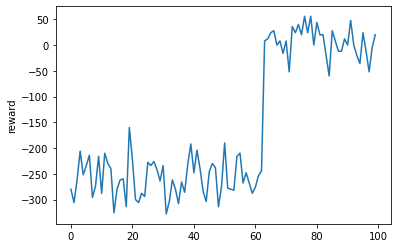

In [76]:
plt.plot(exp1.episode_reward)
plt.ylabel('reward')
plt.show()

In [79]:
def create_orders(df, symbol):
    orders = df.copy(deep = True)
    orders.columns = ['Shares']
    orders.insert(0, 'Symbol', ''.join(symbol))
    orders.insert(1, 'Order', 0)

    orders.ix[orders['Shares'] > 0, 'Order'] = "BUY"
    orders.ix[orders['Shares'] < 0, 'Order'] = "SELL" 

    # make all positive since Sell/Buy is used
    orders['Shares'] = orders['Shares'].abs().astype(int)

    return orders

# not factoring in commission or impact yet...
def compute_portvals(experiment):                                                                                      

    start_val = experiment.portfolio.start_value
    prices = experiment.env.price_train
    orders = experiment.env.trades.copy(deep=True)
    orders.rename(columns={'adjusted close': 'Shares'}, inplace=True)
    orders = orders.sort_index()
    symbol = experiment.symbol
    
    start_date = orders.index[0]
    end_date = orders.index[-1]
    dates = pd.date_range(start_date, end_date)
    
    prices.ffill(axis=0, inplace=True)
    prices.bfill(axis=0, inplace=True)
    prices['Cash'] = 1.0

    trades = prices.copy(deep = True)
    trades.loc[:,:] = 0.0
    trades.rename(columns={'adjusted close': symbol}, inplace=True)

    for date, row in orders.iterrows():
        if row[0] < 0:
            trades.loc[date,symbol] = trades.loc[date,symbol] - row['Shares']
            trades.loc[date,'Cash'] = trades.loc[date,'Cash'] + 1 # track commission multiplier
        else:
            trades.loc[date,symbol] = trades.loc[date,symbol] + row['Shares']
            trades.loc[date,'Cash'] = trades.loc[date,'Cash'] + 1

    print(trades)
    sys.exit()

    trades['Cash'] = (prices.iloc[:,:-1].mul(trades.iloc[:,:-1]).sum(axis=1)*-1).sub(commiss['Cash'],fill_value=0).sub(df_impact['Cash'],fill_value=0)

    holdings = trades.copy(deep = True)
    
    # each row is sum of all previous rows (excluding Cash)
    holdings.iloc[:,:-1] = holdings.rolling(len(holdings), min_periods=1).sum()
    holdings['Cash'][0] = holdings['Cash'][0] + start_val
    holdings.iloc[:,-1] = holdings.iloc[:,-1].rolling(len(holdings), min_periods=1).sum()

    values = holdings.copy(deep = True)
    values.loc[:,:] = 0
    values = prices*holdings

    portvals = values.copy(deep = True)
    portvals = values.sum(axis=1)
    portvals = portvals.to_frame()
    return portvals

In [80]:
compute_portvals(exp1)

              JPM  Cash
Date                   
2017-01-03  100.0   1.0
2017-01-04   50.0   1.0
2017-01-05   50.0   1.0
2017-01-06  154.0   1.0
2017-01-09  100.0   1.0
...           ...   ...
2019-02-04   50.0   1.0
2019-02-05    0.0   1.0
2019-02-06    0.0   1.0
2019-02-07    0.0   1.0
2019-02-08   50.0   1.0

[529 rows x 2 columns]


/home/albert/miniconda3/envs/ml4t/lib/python3.8/site-packages/pandas/core/frame.py:4147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
<ipython-input-79-bea6a918f961>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices['Cash'] = 1.0


SystemExit: 

/home/albert/miniconda3/envs/ml4t/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3449: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
